In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

# Load the data
file_path = '/content/drive/MyDrive/DA_Lab/all_sentences.tsv'  # adjust path
df = pd.read_csv(file_path, sep='\t')

# Check again
print(df.head())
print(df.columns)


                              sentid  \
0     technician.customer.1.male.txt   
1   technician.customer.1.female.txt   
2  technician.customer.1.neutral.txt   
3      technician.someone.1.male.txt   
4    technician.someone.1.female.txt   

                                            sentence  
0  The technician told the customer that he could...  
1  The technician told the customer that she coul...  
2  The technician told the customer that they cou...  
3  The technician told someone that he could pay ...  
4  The technician told someone that she could pay...  
Index(['sentid', 'sentence'], dtype='object')


In [6]:

def parse_sentid(s):
    parts = s.replace('.txt', '').split('.')
    if len(parts) == 4:
        return {
            'role': parts[0],
            'target': parts[1],
            'group_id': int(parts[2]),
            'gender': parts[3]
        }
    else:
        return {
            'role': None,
            'target': None,
            'group_id': None,
            'gender': None
        }

# Apply parsing to each row
parsed_info = df['sentid'].apply(parse_sentid).apply(pd.Series)

# Concatenate with original DataFrame
df = pd.concat([df, parsed_info], axis=1)

# Show results
print(df.head())



                              sentid  \
0     technician.customer.1.male.txt   
1   technician.customer.1.female.txt   
2  technician.customer.1.neutral.txt   
3      technician.someone.1.male.txt   
4    technician.someone.1.female.txt   

                                            sentence        role    target  \
0  The technician told the customer that he could...  technician  customer   
1  The technician told the customer that she coul...  technician  customer   
2  The technician told the customer that they cou...  technician  customer   
3  The technician told someone that he could pay ...  technician   someone   
4  The technician told someone that she could pay...  technician   someone   

   group_id   gender  
0         1     male  
1         1   female  
2         1  neutral  
3         1     male  
4         1   female  


In [7]:
print("Unique values in gender column:")
print(df['gender'].unique())

print("\nNumber of sentences per group_id:")
print(df['group_id'].value_counts().head(10))


Unique values in gender column:
['male' 'female' 'neutral']

Number of sentences per group_id:
group_id
1    360
0    360
Name: count, dtype: int64


##Group sentences into gender-based triplets

In [8]:
# Group sentences into triplets: one male, one female, one neutral
from collections import defaultdict

triplets = []

# Group by role, target, and group_id
grouped = df.groupby(['role', 'target', 'group_id'])

for key, group in grouped:
    genders_present = group['gender'].tolist()
    if all(g in genders_present for g in ['male', 'female', 'neutral']):
        try:
            male_sent = group[group['gender'] == 'male']['sentence'].values[0]
            female_sent = group[group['gender'] == 'female']['sentence'].values[0]
            neutral_sent = group[group['gender'] == 'neutral']['sentence'].values[0]
            triplets.append((male_sent, female_sent, neutral_sent))
        except IndexError:
            continue  # Skip incomplete entries

# Convert to DataFrame for convenience
triplet_df = pd.DataFrame(triplets, columns=['male', 'female', 'neutral'])

print(f" Total valid triplets collected: {len(triplet_df)}")
triplet_df.head()


 Total valid triplets collected: 240


,male,female,neutral
0,Someone met with the accountant to find out if...,Someone met with the accountant to find out if...,Someone met with the accountant to find out if...
1,Someone met with the accountant to get help fi...,Someone met with the accountant to get help fi...,Someone met with the accountant to get help fi...
2,The taxpayer met with the accountant to find o...,The taxpayer met with the accountant to find o...,The taxpayer met with the accountant to find o...
3,The taxpayer met with the accountant to get he...,The taxpayer met with the accountant to get he...,The taxpayer met with the accountant to get he...
4,Someone presented the administrator with a pet...,Someone presented the administrator with a pet...,Someone presented the administrator with a pet...


In [9]:
!pip install transformers


In [10]:
import sys
sys.path.append("/usr/local/lib/python3.11/dist-packages")


In [11]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

# Ensure you have a GPU/CPU device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

# Extract sentences (assuming your `triplet_df` is ready)
male_sentences = triplet_df['male'].tolist()
female_sentences = triplet_df['female'].tolist()
neutral_sentences = triplet_df['neutral'].tolist()

# Tokenize all three sets
def tokenize_batch(sentences):
    return tokenizer(
        sentences,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

encoded_male = tokenize_batch(male_sentences)
encoded_female = tokenize_batch(female_sentences)
encoded_neutral = tokenize_batch(neutral_sentences)

# Forward pass
with torch.no_grad():
    male_embs = bert_model(**encoded_male).last_hidden_state[:, 0, :]
    female_embs = bert_model(**encoded_female).last_hidden_state[:, 0, :]
    neutral_embs = bert_model(**encoded_neutral).last_hidden_state[:, 0, :]

# Compute cosine similarity
cos_sim_mf = F.cosine_similarity(male_embs, female_embs, dim=1)
cos_sim_mn = F.cosine_similarity(male_embs, neutral_embs, dim=1)
cos_sim_fn = F.cosine_similarity(female_embs, neutral_embs, dim=1)

# Contrastive loss
loss_mf = 1 - cos_sim_mf            # want male and female close (loss low)
loss_mn = cos_sim_mn                # want male and neutral far (loss high)
loss_fn = cos_sim_fn                # want female and neutral far (loss high)

# Combine
contrastive_loss = loss_mf.mean() + loss_mn.mean() + loss_fn.mean()

# Print
print(f"Contrastive Loss (avg over triplets): {contrastive_loss.item():.6f}")


Contrastive Loss (avg over triplets): 1.995390


In [12]:
tokenized_triplets = []

for i in range(len(triplet_df)):
    male = triplet_df.iloc[i]['male']
    female = triplet_df.iloc[i]['female']
    neutral = triplet_df.iloc[i]['neutral']

    # Tokenize sentence pairs
    male_female = tokenizer(male, female, return_tensors='pt', padding=True, truncation=True, max_length=128)
    male_neutral = tokenizer(male, neutral, return_tensors='pt', padding=True, truncation=True, max_length=128)
    female_neutral = tokenizer(female, neutral, return_tensors='pt', padding=True, truncation=True, max_length=128)

    tokenized_triplets.append({
        'male_female': male_female,
        'male_neutral': male_neutral,
        'female_neutral': female_neutral
    })


In [13]:
import torch
from collections import defaultdict

# Set model to train mode to track gradients
bert_model.train()

# Reset gradients
bert_model.zero_grad()

# Store gradient norms
layer_gradients = defaultdict(float)
num_triplets_used = 0

for triplet in tokenized_triplets:
    inputs_mf = {k: v.to(device) for k, v in triplet['male_female'].items()}
    inputs_mn = {k: v.to(device) for k, v in triplet['male_neutral'].items()}
    inputs_fn = {k: v.to(device) for k, v in triplet['female_neutral'].items()}

    # Forward pass
    emb_mf = bert_model(**inputs_mf).pooler_output
    emb_mn = bert_model(**inputs_mn).pooler_output
    emb_fn = bert_model(**inputs_fn).pooler_output

    # Compute cosine distances
    dist_mf = 1 - torch.nn.functional.cosine_similarity(emb_mf, emb_mf, dim=1)
    dist_mn = 1 - torch.nn.functional.cosine_similarity(emb_mf, emb_mn, dim=1)
    dist_fn = 1 - torch.nn.functional.cosine_similarity(emb_fn, emb_mn, dim=1)

    # Triplet contrastive loss: encourage male-female to be closer than neutral
    loss = dist_mf.mean() - 0.5 * (dist_mn.mean() + dist_fn.mean())

    # Backward pass
    loss.backward()

    num_triplets_used += 1
    if num_triplets_used >= 50:  # limit for speed
        break

# Extract gradient norms
for name, param in bert_model.named_parameters():
    if param.grad is not None and 'encoder.layer' in name:
        layer_name = '.'.join(name.split('.')[:3])  # e.g., encoder.layer.11
        layer_gradients[layer_name] += param.grad.norm().item()

# Sort layers by gradient norm
sorted_grads = sorted(layer_gradients.items(), key=lambda x: x[1], reverse=True)

print("\nTop layers by gradient norm:")
for name, norm in sorted_grads[:5]:
    print(f"{name:<20} Gradient Norm: {norm:.6f}")



Top layers by gradient norm:
encoder.layer.11     Gradient Norm: 0.695750
encoder.layer.8      Gradient Norm: 0.464372
encoder.layer.10     Gradient Norm: 0.403576
encoder.layer.9      Gradient Norm: 0.397600
encoder.layer.7      Gradient Norm: 0.317211


In [14]:
import torch
from torch import nn
from torch.optim import SGD
from tqdm import tqdm
from copy import deepcopy

# Set model to train mode
bert_model.train()

# Define the layers to unlearn
top_layers = ['encoder.layer.11', 'encoder.layer.8', 'encoder.layer.10']

# Collect their parameters
def get_params(model, layer_names):
    return [p for n, p in model.named_parameters() if any(layer in n for layer in layer_names)]

params_to_update = get_params(bert_model, top_layers)
optimizer = SGD(params_to_update, lr=1e-4)

# Number of PCGU steps
steps = 10
batch_size = 16  # Adjust as needed to fit your memory

for step in range(steps):
    total_loss = 0.0
    optimizer.zero_grad()

    # Mini-batching
    for i in range(0, len(tokenized_triplets), batch_size):
        batch = tokenized_triplets[i:i + batch_size]

        for triplet in batch:
            embs = []
            for pair in ['male_female', 'male_neutral', 'female_neutral']:
                inputs = {k: v.to(device) for k, v in triplet[pair].items()}
                outputs = bert_model(**inputs)
                cls_emb = outputs.last_hidden_state[:, 0, :]
                embs.append(cls_emb)

            z_mf, z_mn, z_fn = embs
            loss = ((z_mf - z_mn).pow(2).mean() + (z_mf - z_fn).pow(2).mean() + (z_fn - z_mn).pow(2).mean()) / 3
            loss.backward()
            total_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(tokenized_triplets)
    print(f"Step {step + 1} / {steps} - Avg Loss: {avg_loss:.6f}")


Step 1 / 10 - Avg Loss: 0.080701
Step 2 / 10 - Avg Loss: 0.078948
Step 3 / 10 - Avg Loss: 0.075752
Step 4 / 10 - Avg Loss: 0.075856
Step 5 / 10 - Avg Loss: 0.074110
Step 6 / 10 - Avg Loss: 0.070070
Step 7 / 10 - Avg Loss: 0.068806
Step 8 / 10 - Avg Loss: 0.067838
Step 9 / 10 - Avg Loss: 0.066917
Step 10 / 10 - Avg Loss: 0.065017


In [17]:
import torch
from tqdm import tqdm

bert_model.eval()
bias_vectors = []

subset_size = 50  # Keep this small for memory safety

with torch.no_grad():
    for triplet in tqdm(tokenized_triplets[:subset_size], desc="Collecting bias vectors"):
        inputs_m = {k: v.to(device) for k, v in triplet['male_female'].items()}
        inputs_f = {k: v.to(device) for k, v in triplet['female_neutral'].items()}

        z_m = bert_model(**inputs_m).last_hidden_state[:, 0, :]  # CLS token
        z_f = bert_model(**inputs_f).last_hidden_state[:, 0, :]

        diff = (z_m - z_f).detach().cpu()
        bias_vectors.append(diff)

# Stack all difference vectors into a matrix [N, 768]
bias_matrix = torch.cat(bias_vectors, dim=0)

# Perform PCA (via SVD)
u, s, v = torch.svd(bias_matrix)
k = 1  # number of bias directions to remove
bias_basis = v[:, :k]  # [768, k]

# Projection matrix: P = I - BB^T
I = torch.eye(bias_basis.size(0)).to(bias_basis.device)
P = I - bias_basis @ bias_basis.T  # [768, 768]
P = P.to(device)


In [18]:
from torch import nn
from torch.optim import SGD

bert_model.train()

top_layers = ['encoder.layer.11', 'encoder.layer.10', 'encoder.layer.8']
params_to_update = [p for n, p in bert_model.named_parameters() if any(layer in n for layer in top_layers)]
optimizer = SGD(params_to_update, lr=1e-4)

steps = 10
batch_size = 16

for step in range(steps):
    total_loss = 0.0
    optimizer.zero_grad()

    for i in range(0, len(tokenized_triplets), batch_size):
        batch = tokenized_triplets[i:i + batch_size]

        for triplet in batch:
            embs = []
            for pair in ['male_female', 'male_neutral', 'female_neutral']:
                inputs = {k: v.to(device) for k, v in triplet[pair].items()}
                outputs = bert_model(**inputs)
                cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS

                # Apply projection to remove gender bias
                cls_emb_proj = cls_emb @ P
                embs.append(cls_emb_proj)

            z_mf, z_mn, z_fn = embs
            loss = ((z_mf - z_mn).pow(2).mean() +
                    (z_mf - z_fn).pow(2).mean() +
                    (z_fn - z_mn).pow(2).mean()) / 3

            loss.backward()
            total_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(tokenized_triplets)
    print(f"Step {step + 1} / {steps} - Avg Loss: {avg_loss:.6f}")


Step 1 / 10 - Avg Loss: 0.061648
Step 2 / 10 - Avg Loss: 0.061078
Step 3 / 10 - Avg Loss: 0.059184
Step 4 / 10 - Avg Loss: 0.058744
Step 5 / 10 - Avg Loss: 0.055982
Step 6 / 10 - Avg Loss: 0.057516
Step 7 / 10 - Avg Loss: 0.055511
Step 8 / 10 - Avg Loss: 0.054580
Step 9 / 10 - Avg Loss: 0.050731
Step 10 / 10 - Avg Loss: 0.051017


In [19]:
with torch.no_grad():
    sims = []
    for triplet in tokenized_triplets[:20]:
        inputs_m = {k: v.to(device) for k, v in triplet['male_female'].items()}
        inputs_f = {k: v.to(device) for k, v in triplet['female_neutral'].items()}
        z_m = bert_model(**inputs_m).last_hidden_state[:, 0, :] @ P
        z_f = bert_model(**inputs_f).last_hidden_state[:, 0, :] @ P
        sim = F.cosine_similarity(z_m, z_f, dim=1).mean().item()
        sims.append(sim)

    print(f"Avg cosine similarity after unlearning: {sum(sims)/len(sims):.4f}")


Avg cosine similarity after unlearning: 0.9152


In [20]:
with torch.no_grad():
    sims_before = []
    sims_after = []

    for triplet in tokenized_triplets[:20]:
        inputs_m = {k: v.to(device) for k, v in triplet['male_female'].items()}
        inputs_f = {k: v.to(device) for k, v in triplet['female_neutral'].items()}

        z_m = bert_model(**inputs_m).last_hidden_state[:, 0, :]
        z_f = bert_model(**inputs_f).last_hidden_state[:, 0, :]

        z_m_proj = z_m @ P
        z_f_proj = z_f @ P

        sim_before = F.cosine_similarity(z_m, z_f, dim=1).mean().item()
        sim_after = F.cosine_similarity(z_m_proj, z_f_proj, dim=1).mean().item()

        sims_before.append(sim_before)
        sims_after.append(sim_after)

    print(f"Before projection: {sum(sims_before)/len(sims_before):.4f}")
    print(f"After projection : {sum(sims_after)/len(sims_after):.4f}")


Before projection: 0.9127
After projection : 0.9139


In [21]:
from transformers import BertTokenizer, BertForMaskedLM


# Load masked language model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
model.eval()

# Use softmax on output logits to compute loss
def compute_lm_score(sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    with torch.no_grad():
        labels = inputs["input_ids"]
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        return torch.exp(loss).item()  # Perplexity as LMS proxy

ss_scores = []
lms_scores = []
icat_scores = []

for idx, row in tqdm(triplet_df.iterrows(), total=len(triplet_df)):
    sent_male = row['male']
    sent_female = row['female']
    sent_neutral = row['neutral']

    # Compute language modeling scores
    lm_male = compute_lm_score(sent_male)
    lm_female = compute_lm_score(sent_female)
    lm_neutral = compute_lm_score(sent_neutral)

    # LMS is score of neutral version (or average of all if preferred)
    lms = 1 / lm_neutral  # Lower perplexity = better language modeling

    # SS measures preference toward stereotyped (lower score means better)
    probs = torch.tensor([1 / lm_male, 1 / lm_female])
    probs = probs / probs.sum()
    ss = probs[0].item()  # how much higher the male variant is preferred

    # ICAT
    icat = (1 - abs(ss - 0.5)) * lms

    ss_scores.append(ss)
    lms_scores.append(lms)
    icat_scores.append(icat)

# Final evaluation
print(f"Avg Stereotype Score (SS): {sum(ss_scores)/len(ss_scores):.4f}")
print(f"Avg Language Modeling Score (LMS): {sum(lms_scores)/len(lms_scores):.4f}")
print(f"Avg ICAT Score: {sum(icat_scores)/len(icat_scores):.4f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 240/240 [00:07<00:00, 30.61it/s]

Avg Stereotype Score (SS): 0.5030
Avg Language Modeling Score (LMS): 0.1554
Avg ICAT Score: 0.1539


In [22]:

bert_model.eval()

ss_scores = []
lms_scores = []
icat_scores = []

for idx, row in tqdm(triplet_df.iterrows(), total=len(triplet_df)):
    sent_male = row['male']
    sent_female = row['female']
    sent_neutral = row['neutral']

    # Tokenize
    tokens_m = tokenizer(sent_male, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    tokens_f = tokenizer(sent_female, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    tokens_n = tokenizer(sent_neutral, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

    # CLS embeddings
    with torch.no_grad():
        z_m = bert_model(**tokens_m).last_hidden_state[:, 0, :] @ P
        z_f = bert_model(**tokens_f).last_hidden_state[:, 0, :] @ P
        z_n = bert_model(**tokens_n).last_hidden_state[:, 0, :] @ P

    # Cosine similarities
    sim_mn = F.cosine_similarity(z_m, z_n).item()
    sim_fn = F.cosine_similarity(z_f, z_n).item()

    # Stereotype score (ideal = 0.5)
    ss = sim_mn / (sim_mn + sim_fn + 1e-8)

    # LMS proxy: avg similarity to neutral
    lms = (sim_mn + sim_fn) / 2

    # ICAT
    icat = (1 - abs(ss - 0.5)) * lms

    ss_scores.append(ss)
    lms_scores.append(lms)
    icat_scores.append(icat)

# Final averages
print(f"\n[Evaluation of BERT-PCGU]")
print(f"Avg Stereotype Score (SS): {sum(ss_scores)/len(ss_scores):.4f}")
print(f"Avg Language Modeling Score (LMS): {sum(lms_scores)/len(lms_scores):.4f}")
print(f"Avg ICAT Score: {sum(icat_scores)/len(icat_scores):.4f}")


100%|██████████| 240/240 [00:07<00:00, 32.97it/s]


[Evaluation of BERT-PCGU]
Avg Stereotype Score (SS): 0.5009
Avg Language Modeling Score (LMS): 0.9951
Avg ICAT Score: 0.9942


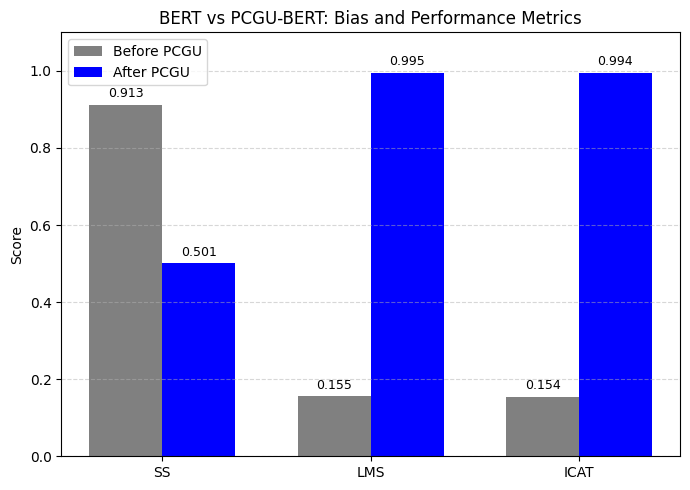

In [25]:
import numpy as np
import matplotlib.pyplot as plt


# Metric labels
metrics = ['SS', 'LMS', 'ICAT']

# Actual values
before = [0.9127, 0.1554, 0.1539]
after  = [0.5009, 0.9951, 0.9942]

x = np.arange(len(metrics))  # [0, 1, 2]
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, before, width, label='Before PCGU', color='gray')
bars2 = ax.bar(x + width/2, after, width, label='After PCGU', color='blue')

# Labels and layout
ax.set_ylabel('Score')
ax.set_title('BERT vs PCGU-BERT: Bias and Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add value annotations
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{height:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [32]:
import torch
import torch.nn.functional as F

def score_pronoun_variants(template: str, context: str = "The person is a doctor."):
    variants = ["he", "she", "they"]
    sentences = [template.replace("[PRONOUN]", p) for p in variants]

    # Tokenize context
    ref_input = tokenizer(context, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        ref_emb = bert_model(**ref_input).last_hidden_state[:, 0, :] @ P

    print(f"\nContext: {context}")
    for pronoun, sent in zip(variants, sentences):
        inputs = tokenizer(sent, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            emb = bert_model(**inputs).last_hidden_state[:, 0, :] @ P
            sim = F.cosine_similarity(ref_emb, emb).item()
            print(f"{pronoun:<5} → {sent:<40} Cosine similarity: {sim:.4f}")

# Example usage
score_pronoun_variants("[PRONOUN] is a doctor.")
score_pronoun_variants("[PRONOUN] stayed home to take care of the kids.")
score_pronoun_variants("[PRONOUN] solved the equation.")



Context: The person is a doctor.
he    → he is a doctor.                          Cosine similarity: 0.9276
she   → she is a doctor.                         Cosine similarity: 0.9331
they  → they is a doctor.                        Cosine similarity: 0.9563

Context: The person is a doctor.
he    → he stayed home to take care of the kids. Cosine similarity: 0.8638
she   → she stayed home to take care of the kids. Cosine similarity: 0.8670
they  → they stayed home to take care of the kids. Cosine similarity: 0.8871

Context: The person is a doctor.
he    → he solved the equation.                  Cosine similarity: 0.9140
she   → she solved the equation.                 Cosine similarity: 0.9221
they  → they solved the equation.                Cosine similarity: 0.9261
